In [ ]:
!pip install --quiet transformers seaborn datasets evaluate rouge_score nltk numpy spacy lexrank

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 4.9 MB/s eta 0:00

In [ ]:
!pip install --quiet --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 9.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/RuSportSum/train_during_match_pairs_data1.csv" /content/train.csv
!cp "/content/drive/MyDrive/RuSportSum/eval_during_match_pairs_data1.csv" /content/eval.csv
!cp "/content/drive/MyDrive/RuSportSum/test_during_match_pairs_data1.csv" /content/test.csv

In [ ]:
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from lexrank import LexRank
from spacy.lang.ru.stop_words import STOP_WORDS

import nltk
from nltk.tokenize import sent_tokenize
import numpy as np
from datasets import Dataset
from datasets import load_dataset, load_metric
from sklearn.model_selection import train_test_split
import transformers
from transformers import (
    AutoConfig,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    HfArgumentParser,
    MBart50TokenizerFast,
    MBartTokenizer,
    MBartTokenizerFast,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    set_seed,
)
import evaluate

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
train = pd.read_csv('/content/train.csv')
eval = pd.read_csv('/content/eval.csv')
test = pd.read_csv('/content/test.csv')
train

,match_id,news_id,name,team1,team2,content,news_name,news_body,news_name_body
0,479927,149901417,Квалификация ЧМ: Европа,Португалия,Россия,0 минута. Всем привет! Непобедимая сборная Рос...,Португалия – Россия. Акинфеев установил рекорд...,Форвард сборной Португалии Элдер Поштига откры...,Португалия – Россия. Акинфеев установил рекорд...
1,286145,129843619,Россия. Премьер-лига,Ростов,Зенит,"0 минута. Здравствуйте, друзья. 28-й тур чемпи...",Плетикоса получил травму в матче с «Зенитом»,Вратарь «Ростова» Стипе Плетикоса получил трав...,Плетикоса получил травму в матче с «Зенитом» &...
2,1095102,1038508209,Товарищеские матчи (сборные),Германия,Англия,0 минута. Всем привет! Можно сколько угодно не...,Германия – Англия. Кейн перед голом повторил п...,Форвард сборной Англии Харри Кейн отыграл один...,Германия – Англия. Кейн перед голом повторил п...
3,471129,137844886,Кубок Гагарина,ЦСКА,СКА,10 минута. Федоров у борта в чужой зоне впечат...,Прохоркин набрал первое очко в плей-офф,Нападающий ЦСКА Николай Прохоркин в четвертом ...,Прохоркин набрал первое очко в плей-офф & Напа...
4,455471,141780495,Чемпионат Европы,Испания,Италия,0 минута. Ради такого дела Дель Боске снова ре...,Кьеллини получил травму бедра в финале Евро-2012,Защитник «Ювентса» и сборной Италии Джорджо Кь...,Кьеллини получил травму бедра в финале Евро-20...
...,...,...,...,...,...,...,...,...,...
3434,306385,129852656,Англия. Премьер-лига,Манчестер Юнайтед,Манчестер Сити,35 минута. Сильва слишком сильно подал стандар...,Эванс получил красную карточку за фол на Балот...,Защитник «Манчестер Юнайтед» Джонни Эванс был ...,Эванс получил красную карточку за фол на Балот...
3435,296562,96016458,Чемпионат мира,Чехия,Россия,"0 минута. Ну что, попробуем помечтать? Илья Ко...",Артюхин разбил голову Рахунеку,Защитник сборной Чехии Карел Рахунек получил т...,Артюхин разбил голову Рахунеку & Защитник сбор...
3436,1047368,1035867637,Испания. Ла Лига,Барселона,Бетис,0 минута. В 2015 «Барса» взяла почти все возмо...,«Барселона» – «Бетис». Месси проводит 500-й ма...,Нападающий «Барселоны» Лионель Месси вышел в с...,«Барселона» – «Бетис». Месси проводит 500-й ма...
3437,955670,1025858505,Англия. Премьер-лига,Астон Вилла,Манчестер Юнайтед,7 минута. Окоре здорово прорвался по флангу. А...,«Астон Вилла» – «МЮ». Агбонлахор удален с поля,Форвард «Астон Виллы» Габриэль Агбонлахор был ...,«Астон Вилла» – «МЮ». Агбонлахор удален с поля...


In [ ]:
data = pd.concat([train, eval, test])
data['len_content'] = data['content'].apply(lambda x: len(str(x).split()))
data['len_news_name_body'] = data['news_name_body'].apply(lambda x: len(str(x).split()))
data[['len_content', 'len_news_name_body']].describe()

,len_content,len_news_name_body
count,4089.000000,4089.000000
mean,369.533138,65.782343
std,228.648106,20.079114
min,1.000000,25.000000
25%,206.000000,52.000000
50%,324.000000,62.000000
75%,482.000000,75.000000
max,1730.000000,313.000000


<Axes: xlabel='len_news_name_body'>

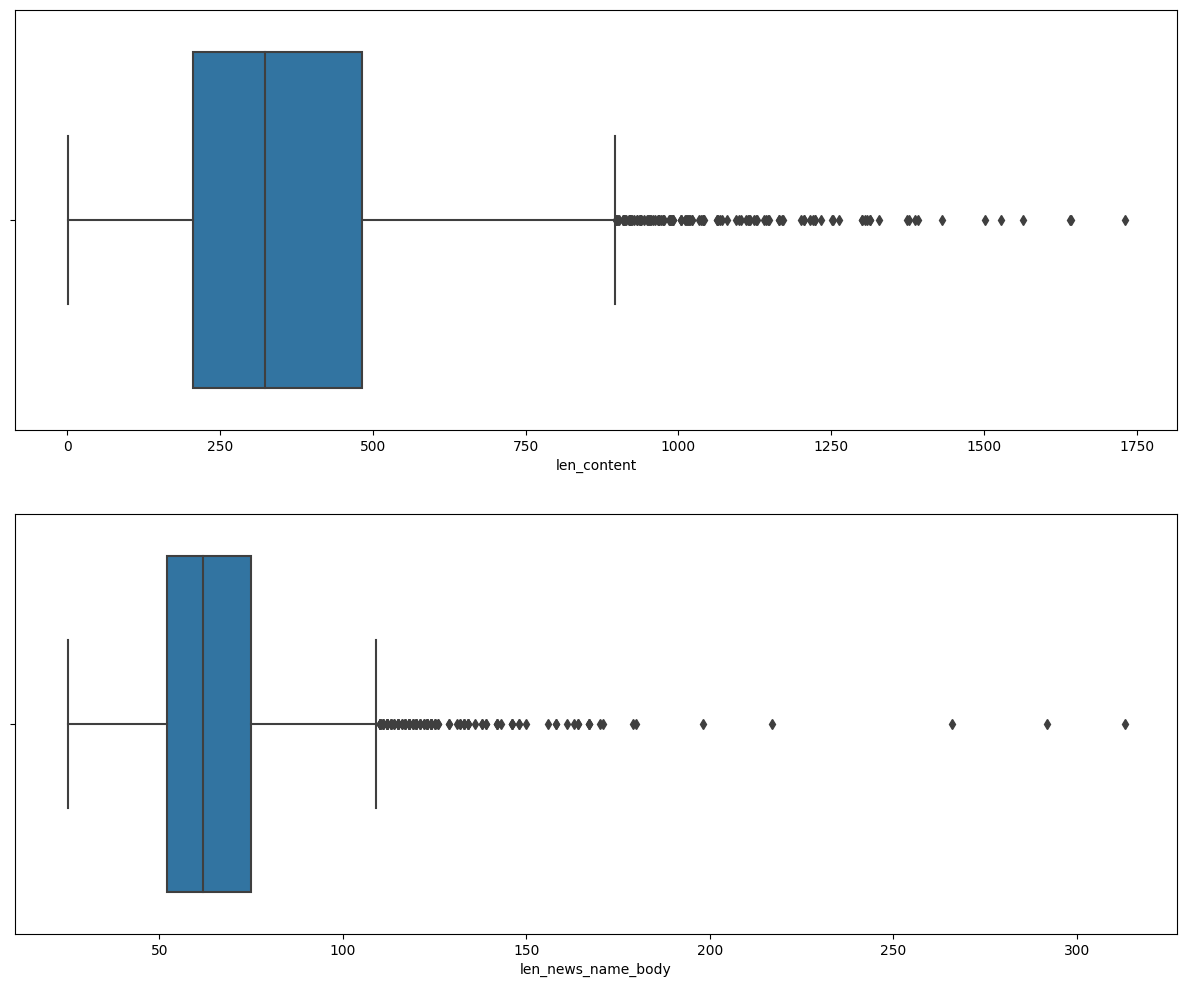

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

sns.boxplot(ax=axes[0], x='len_content', data=data)
sns.boxplot(ax=axes[1], x='len_news_name_body', data=data)

### Новости, посвященные какому-то событию

#### Fine-tuning модели mbart-large-cc25

In [ ]:
SEED = 3
lang = 'ru_RU'
set_seed(SEED)

In [ ]:
dataset = load_dataset("csv", data_files={'train': 'train.csv', 'eval': 'eval.csv', 'test': 'test.csv'})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-62b45a2ffe343eae/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset['train'][0]

{'match_id': 479927,
 'news_id': 149901417,
 'name': 'Квалификация ЧМ: Европа',
 'team1': 'Португалия',
 'team2': 'Россия',
 'content': '0 минута. Всем привет! Непобедимая сборная России сегодня гостит у сборной Португалии. Смотрим вместе! 0 минута. Не все верят в непобедимость сборной России. Букмекерская контора WIlliam Hill, например, выставила на победу португальцев коэффициент 1,8, на победу россиян - 4,6, а на ничью - 3,4. 0 минута. Португалия: Патрисиу, Велозу, Коэнтрау, Алвеш, Нету, Ж. Перейра, Мейрелеш, Моутинью, Вийеринья, Поштига, Криштиану Роналду (к). 0 минута. Россия: Акинфеев, Анюков, В. Березуцкий, Игнашевич, Д. Комбаров, Денисов (к), Широков, Файзулин, Быстров, Жирков, Кержаков. 3 минута. Пока происходящее буквально самую малость напоминает вчерашний матч молодежек Испании и России. 9 минута. гол! 1:0! После навеса со штрафного Поштига подставил ногу, и мяч от штанги залетел в ворота. Красиво, черт побери. 30 минута. И снова замена у сборной России! Вместо травмированн

In [ ]:
model_name = "facebook/mbart-large-cc25"

config = transformers.AutoConfig.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, config=config)

In [ ]:
model.config.decoder_start_token_id = tokenizer.convert_tokens_to_ids(lang)

In [ ]:
tokenizer.src_lang = lang
tokenizer.tgt_lang = lang

# Для mbart нужен токен языка
forced_bos_token_id = (tokenizer.lang_code_to_id[lang])

model.config.forced_bos_token_id = forced_bos_token_id

In [ ]:
text_column = 'content'
summary_column = 'news_name_body'

In [ ]:
max_source_length = 512
max_target_length = 300
padding = 'max_length'
ignore_pad_token_for_loss = True

In [ ]:
def preprocess_function(examples):
  inputs, targets = [], []

  for i in range(len(examples[text_column])):
      if examples['name'][i] and examples['team1'][i] and examples['team2'][i] and examples[text_column][i] and examples[summary_column][i]:
          inputs.append('</s>'.join([examples['name'][i], examples['team1'][i], examples['team2'][i], examples[text_column][i]]))
          targets.append(examples[summary_column][i])

  model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

  labels = tokenizer(text_target=targets, max_length=max_target_length, padding=padding, truncation=True)

  # Для игнорирования паддинга в loss
  if padding == "max_length" and ignore_pad_token_for_loss:
      labels["input_ids"] = [
          [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
      ]

  model_inputs["labels"] = labels["input_ids"]

  return model_inputs

In [ ]:
train_dataset = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=2,
    remove_columns=['match_id', 'news_id', 'name', 'team1', 'team2', 'content', 'news_name', 'news_body', 'news_name_body'],
    )

Map (num_proc=2):   0%|          | 0/3439 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/500 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
# Data collator
label_pad_token_id = -100
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

In [ ]:
# Метрика
metric = evaluate.load("rouge")

In [ ]:
def postprocess_text(preds, labels):
  preds = [pred.strip() for pred in preds]
  labels = [label.strip() for label in labels]

  # rougeLSum ожидает новую строку после каждого предложения
  preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
  labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

  return preds, labels

In [ ]:
def compute_metrics(eval_preds):
  preds, labels = eval_preds
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  if ignore_pad_token_for_loss:
      labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

  result = metric.compute(predictions=decoded_preds, references=decoded_labels, tokenizer=lambda x: x.split())
  result = {k: round(v * 100, 4) for k, v in result.items()}
  prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
  result["gen_len"] = np.mean(prediction_lens)
  return result

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir=".",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=16,
    gradient_checkpointing=True,
    optim="adafactor",
    logging_steps=100,
    evaluation_strategy='epoch',
    save_strategy="epoch",
    load_best_model_at_end=True,
    predict_with_generate=True
    )

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset['train'],
    eval_dataset=train_dataset['eval'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
    )

train_result = trainer.train()

You're using a MBartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
0,No log,1.539165,22.095200,10.837200,19.208700,21.303400,103.949597
1,1.816300,1.348116,33.091300,15.496500,28.057600,31.231100,122.881048
2,1.816300,1.319193,33.212200,15.862200,28.123900,31.226500,127.181452


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


In [ ]:
trainer.save_model('/content/drive/MyDrive/RuSportSum/save_model')

#### Оценка качества настроенного mBART на тестовом наборе данных

In [ ]:
predict_results = trainer.predict(
    train_dataset['test'],
    metric_key_prefix="predict",
    max_length=max_target_length,
    num_beams=3
)
metrics = predict_results.metrics

In [ ]:
metrics

{'predict_loss': 1.2984423637390137,
 'predict_rouge1': 33.2065,
 'predict_rouge2': 15.6639,
 'predict_rougeL': 28.0296,
 'predict_rougeLsum': 31.1308,
 'predict_gen_len': 127.68666666666667,
 'predict_runtime': 201.6315,
 'predict_samples_per_second': 0.744,
 'predict_steps_per_second': 0.188}

In [ ]:
predictions = []
if trainer.is_world_process_zero():
  if training_args.predict_with_generate:
    predictions = tokenizer.batch_decode(
        predict_results.predictions, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    predictions = [pred.strip() for pred in predictions]

In [ ]:
output_prediction_file = "generated_predictions.txt"
with open(output_prediction_file, "w", encoding='utf-8') as writer:
  writer.write("\n".join(predictions).encode('utf-8').decode("utf-8"))

In [ ]:
print('часть матча: ', dataset['test'][0]['content'])
print('оригинальная новость: ', dataset['test'][0]['news_name_body'])
print('предсказанная новость: ', predictions[0])

часть матча:  4 минута. гол! Торесен! 0:1! Незамысловато поборолись на вбрасывании и спокойно разыграли наигранную комбинацию. 31 минута. Уставший Торесен  предпочел бросить от левого края синей линии, Лазушин на месте. 32 минута. гол! 1:5! Торесен! Кутейкин великолепной длинной передачей вывел Торесена к воротам, который немного срезал угол и попал в промежуток между штангой и плечом голкипера! Вот это уже пахнет разгромом! 38 минута. В контратаке Торесен чуть было не затолкал шайбу Лазушину в ближний угол! 39 минута. гол! 1:6! Хет-трик Торесена! Радулов из-за ворот выдал передачу на Торесена, который в касание оформил еще одну результативный бросок, а его партнер - очередной ассистентский балл.
оригинальная новость:  Торесен сделал второй хет-трик в сезоне & Нападающий «Салавата Юлаева» Патрик Торесен в матче с «Локомотивом» сделал второй хет-трик в сезоне. Норвежский форвард открыл счет в матче на 4-й минуте, а затем двумя голами подряд довел преимущество «Салавата» до 5 шайб (6:1).

In [ ]:
print('часть матча: ', dataset['test'][1]['content'])
print('оригинальная новость: ', dataset['test'][1]['news_name_body'])
print('предсказанная новость: ', predictions[1])

часть матча:  0 минута. Приветствую, читатель. Матч Россия – Литва начнется в 19:00 по московскому времени. Запасись попкорном – сегодня ты увидишь примерную игру сборной России на Чемпионате Европы. 0 минута. 90% пользователей приложений Sports.ru и Scores & Video голосуют за победу России над Литвой, а букмекеры оценивают нашу победу в 1.26. За ничью предлагают 6, а за победу гостей – 16. Теперь твой ход. 0 минута. Игра настолько товарищеская, что президент РФС Виталий Мутко и президент ФФ Литвы Эдвинас Эймонтас пожали друг-другу руки. 4 минута. Темп игры очень низок, но Россия прибрала инициативу в свои руки. Было несколько подходов к воротам Литвы, но ничем опасным это не закончилось. 6 минута. Кстати, у Сергея Игнашевича 115-й матч в составе сборной России. Это мощно. 18 минута. Теперь и первая атака Литвы: Миколюнас замыкал дальнюю подачу с правого фланга, но удар приходится в высоко летевшего воробья. 43 минута. Самедов – умница! Решил обмануть голкипера Литвы со штрафного – не 

In [ ]:
print('часть матча: ', dataset['test'][2]['content'])
print('оригинальная новость: ', dataset['test'][2]['news_name_body'])
print('предсказанная новость: ', predictions[2])

часть матча:  4 минута. Дзагоев оказался в центре штрафной "Спартака", где ему не удается замкнуть навес Мамаева. А ведь можно было в упор расстрелять ворота Фредриксона... 9 минута. Овсиенко получил желтую, и вдобавок пенальти в ворота его команды будет. Зашел Думбия в штрафную "Спартака", где его и сбил зачем-то Евгений. 10 минута. Не забивает с одиннадцатиметровой отметки Игнашевич! Фредриксону удается отбить, после чего Вагнер не успел затолкать мяч в сетку. 26 минута. Вагнер Лав, как же можно не забивать с такой позиции? С правого фланга скинул Думбия бразильцу мяч прямо на ногу, и тот, почти обойдя Фредриксона, пробил на рекламный щит за воротами. Александр Бубнов вспоминал, что Константин Иванович Бесков в таких случаях говорил: "Сними валенок!" 30 минута. Дзагоев получил мяч в центре и скинул на Вагнера, от которого тот ушел в ноги гостям. 34 минута. гол! 1:0 - Вагнер забивает-таки. Оставили бразильца на линии штрафной защитника нальчан, так его и не встретившие, и тот забил в 